# Quest07: 뉴스 요약봇 만들기

### 평가문항에 맞춰서 작성
**1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.**  
-> 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

**2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.**  
-> 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

**3. Extractive 요약을 시도해 보고 Abstractive 요약 결과와 함께 비교해 보았다.**  
-> 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

# Import

In [62]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
import time

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<br/>

---

<br/>

# <span style="background-color:#E6E6FA">  1. 데이터 수집하기  </span>

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# 데이터 확인
data.sample(10) # headlines, text

,headlines,text
35825,Man arrested for smuggling gold powder hidden ...,A man has been arrested from Pune airport for ...
93889,Big B shares old pic of Ranbir; calls him supe...,Actor Amitabh Bachchan took to Twitter to shar...
63820,Faheem Ashraf 1st Pakistani bowler to take a T...,All-rounder Faheem Ashraf became the first Pak...
66418,"Not your fault if you're depressed, don't hide...","Actress Deepika Padukone, in an article she pe..."
71572,Patanjali told to stop airing ad targeting Lux...,The Bombay High Court has asked Baba Ramdev-le...
12371,Uber's dealmaking head resigns amid sexual mis...,Uber's VP of corporate development Cameron Poe...
88027,"PoK anthem played, terrorists' pics displayed ...",The national anthem of Pakistan-occupied Kashm...
35452,India protests as Pak stops envoy from meeting...,"India on Sunday said it has lodged a ""strong p..."
85299,Bathing suit featuring man's hairy chest goes ...,A bathing suit introduced by fashion brand Bel...
92733,"Tata, Patanjali interested in Sahara propertie...","A number of corporates, including Tata, Godrej..."


# <span style="background-color:#E6E6FA"> 1-0 편의를 위해 사용한 함수 정리 </span>

In [4]:
class LogTool():
    '''
    로그 클래스
    '''
    
    def list_to_line(list: list):
        '''
        리스트

        Args:
            list: list를 line으로 출력
        '''
        msg = ""
        
        for i, e in enumerate(list):
            msg += str(i+1) + ': ' + str(e) + '\n'
            
        print(msg)

# test_list = ['asdasd','asdbfbfbfb','hthdd','asyryry']
# LogTool.list_to_line(test_list)

# <span style="background-color:#E6E6FA"> 2-0 데이터 전처리에 사용한 def 정리 </span>

In [5]:
def check_unique_data(data, col='all'):
    '''
    데이터의 유니크한 데이터 수를 출력하는 함수
    
    Args:
        data: 데이터 프레임을 받음
        col: 데이터 프레임의 컬럼명을 받음
    '''
    
    if col == 'all':
        try:
            for x in data.columns:
                print(f'>>> {x}의 유니크한 데이터 수: ', data[x].nunique())
        except:
            print('>>> 올바른 데이터 형식이 아닙니다.')

    else:
        try:
            print(f'>>> {col}의 유니크한 데이터 수: ', data[col].nunique())
        except:
            print('>>> 올바른 데이터 형식이 아니거나 포함되지 않은 컬럼입니다.')
        
        
def preprocess_sentence(sentence, remove_stopwords=True):
    '''
    문장에서 아래와 같은 전처리를 해주는 함수
    
     Args:
        sentence: 문장 데이터를 받음
        remove_stopwords: 불용어를 처리할지 말지를 정하는 값(True: 처리O, False: 처리X)
    
    '''
    
    sentence = sentence.lower()    # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text   # <> 등 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (~~) 제거
    sentence = re.sub('""', '', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거. Her's => Her
    sentence = re.sub("[^a-zA-Z]", " ", sentence)   # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 3개 이상이면 2개로 변경 ummmm 이런거
    
    # 불용어 제거 (in text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (in headlines) 제거하면 오히려 어색함
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

<br/>

---

<br/>

# <span style="background-color:#E6E6FA"> 2. 데이터 전처리하기 (추상적 요약) </span>

### <span style="background-color:#fff5b1"> 유니크한 데이터 수 파악(중복값 제거를 위한 작업) </span>

In [6]:
# check_unique_data(data, 'text')
check_unique_data(data) # data 전체의 유니크한 데이터 출력

>>> headlines의 유니크한 데이터 수:  98280
>>> text의 유니크한 데이터 수:  98360


### <span style="background-color:#fff5b1"> text는 본문이기 때문에 중복값 제거 </span> 

In [7]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('>>> 전체 샘플수 :',(len(data)))

>>> 전체 샘플수 : 98360


### <span style="background-color:#fff5b1"> 결측치(null)값 확인 및 제거 </span> 

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### <span style="background-color:#fff5b1"> 텍스트 정규화 및 불용어 제거 </span> 

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print(">>> 정규화 사전의 수: ",len(contractions))

>>> 정규화 사전의 수:  120


In [10]:
print('>>> 불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

>>> 불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same'

### <span style="background-color:#fff5b1"> 데이터 전처리 결과를 확인하기 위해 임의의 데이터 호출 </span> 

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print(">>> text: ", preprocess_sentence(temp_text))
print(">>> headline:", preprocess_sentence(temp_headline, False))  

>>> text:  everything bought great infact ordered twice third ordered wasfor mother father
>>> headline: great way to start the day


### <span style="background-color:#fff5b1"> 본문 데이터인 text는 불용어를 제거하는 전처리를 진행 </span> 

In [12]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
LogTool.list_to_line(clean_text[:5])

1: saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
2: kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit
3: new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
4: aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illn

In [13]:
# 전처리 데이터 백업
clean_text_backup = clean_text

In [14]:
# 전처리 데이터 불러오기
# clean_text = clean_text_backup

### <span style="background-color:#fff5b1"> 제목 데이터인 headline은 불용어를 제거하지 않는 전처리를 진행 </span> 

In [15]:
clean_headline = []

# 전체 headlines 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False)) # headlines에 대한 불용어 처리 False 와 True 비교

# 전처리 후 출력
LogTool.list_to_line(clean_headline[:5])

1: upgrad learner switches to career in ml al with salary hike
2: delhi techie wins free food from swiggy for one year on cred
3: new zealand end rohit sharma led india match winning streak
4: aegon life iterm insurance plan helps customers save tax
5: have known hirani for yrs what if metoo claims are not true sonam



In [16]:
# 전처리 데이터 백업
clean_headline_backup = clean_headline

In [17]:
# 전처리 데이터 불러오기
# clean_headline = clean_headline_backup

### <span style="background-color:#fff5b1"> 빈값 변환 및 처리 </span> 

In [18]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### <span style="background-color:#fff5b1"> 샘플 최대 길이 설정(분포 확인) </span> 

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.097763318422125
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.29956283041887


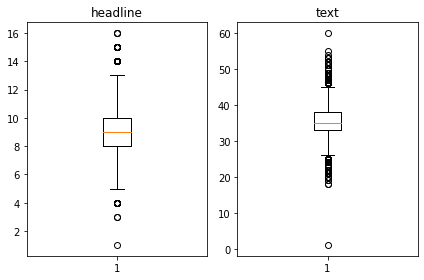

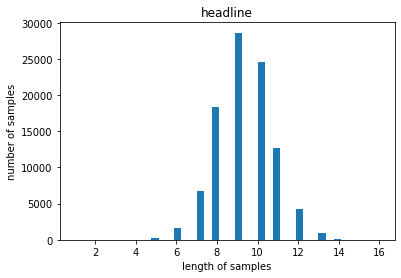

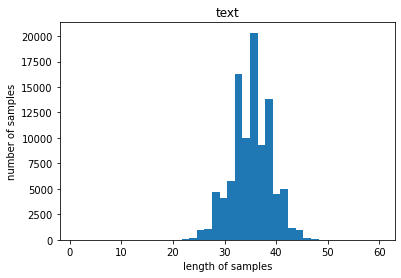

In [20]:
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### <span style="background-color:#fff5b1"> 샘플 최대 길이 설정(변수 설정) </span> 

In [21]:
# 평균보다 조금 크고 최대보다 작은 값으로 설정
text_max_len = 37
headline_max_len = 10

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
    print('>>> 전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [23]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

>>> 전체 샘플 중 길이가 37 이하인 샘플의 비율: 0.7381049206994713
>>> 전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


### <span style="background-color:#fff5b1"> 최대 길이보다 작은 값으로 데이터 수정 </span> 

In [24]:
def below_maxlen_data(data, max_len: int, col: str):
    '''
    maxlen 보다 짧은 단어를 골라내는 함수
    
    Args:
        data: 데이터 프레임을 받음
        max_len: 최대 길이를 받음
        col: 데이터 프레임의 컬럼명을 받음
    '''
    print(f'>>> {col}의 처리 전 갯수: ', len(data[col]))
    data = data[data[col].apply(lambda x: len(x.split()) <= max_len)]
    print(f'<<< {col}의 처리 후 갯수: ', len(data[col]))
    
    return data

In [25]:
# text값 최대 길이로 처리
data = below_maxlen_data(data, text_max_len, 'text')

>>> text의 처리 전 갯수:  98360
<<< text의 처리 후 갯수:  72600


In [26]:
# headlines값 최대 길이로 처리
data = below_maxlen_data(data, headline_max_len, 'headlines')

>>> headlines의 처리 전 갯수:  72600
<<< headlines의 처리 후 갯수:  58935


In [27]:
print('>>> 전체 샘플수 :',(len(data)))

>>> 전체 샘플수 : 58935


### <span style="background-color:#fff5b1"> 시작 & 종료 토큰 추가하기 </span> 

In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가.

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
16,karan johar tabu turn showstoppers on opening ...,filmmaker karan johar actress tabu turned show...,sostoken karan johar tabu turn showstoppers on...,karan johar tabu turn showstoppers on opening ...


### <span style="background-color:#fff5b1"> 훈련, 테스트 데이터 나누기 </span> 

In [29]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [30]:
# 훈련 데이터 테스트 데이터 분리

indices = np.arange(encoder_input.shape[0])  # encoder_input과 크기와 형태가 같은 정수 시퀀스 생성
np.random.shuffle(indices)                   # 순서를 랜덤하게 섞어줍니다
print(indices) # 랜덤한 정수 시퀀스 생성!

[57773  2578 32185 ... 15091  9682  3110]


In [31]:
# 샘플 순서를 랜덤 시퀀스를 이용해서 정의해줌

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [32]:
# 8:2로 훈련셋 테스트셋 분리

n_of_val = int(len(encoder_input)*0.2)
print('>>> 테스트 데이터의 수 :', n_of_val)

>>> 테스트 데이터의 수 : 11787


In [33]:
# 테스트 데이터의 갯수를 이용해 전체 데이터를 양분해줌

encoder_input_train = encoder_input[:-n_of_val] # 뒤로 n_of_val개 빼고 나머지
decoder_input_train = decoder_input[:-n_of_val] 
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # 앞에 n_of_val개 빼고 나머지
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('>>> 훈련 데이터의 개수 : ', len(encoder_input_train))
print('>>> 훈련 레이블의 개수 : ', len(decoder_input_train))
print('>>> 테스트 데이터의 개수 : ', len(encoder_input_test))
print('>>> 테스트 데이터의 개수 : ', len(decoder_input_test))

>>> 훈련 데이터의 개수 :  47148
>>> 훈련 레이블의 개수 :  47148
>>> 테스트 데이터의 개수 :  11787
>>> 테스트 데이터의 개수 :  11787


In [34]:
def tokenizer_info(tokenizer, threshold = 1, rare_count = 0, total_freq = 0, rare_freq = 0):
    '''
    tokenizer의 정보를 출력해주는 함수
    
    Args:
        threshold: 한계점
        rare_count: 등장 빈도수가 threshold보다 작은 단어의 개수를 count
        total_freq: 훈련 데이터의 전체 단어 빈도수 총 합
        rare_freq: 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합
    '''

    total_count = len(tokenizer.word_index)      # 단어의 수


    # 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if (value < threshold) :
            rare_count = rare_count + 1
            rare_freq = rare_freq + value

    print('>>> 단어 집합의 크기 : ', total_count)
    print('>>> 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
    print('>>> 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
    print(">>> 단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
    print(">>> 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

### <span style="background-color:#fff5b1"> text 데이터 토크나이저 생성 후 확인 </span> 

In [35]:
src_tokenizer = Tokenizer()    # 토크나이저 생성 - 입력된 훈련 데이터로부터 단어집합 생성 가능하게 해줌
src_tokenizer.fit_on_texts(encoder_input_train)       # 입력된 데이터로부터 단어 집합 생성

In [36]:
tokenizer_info(src_tokenizer, 8)

>>> 단어 집합의 크기 :  54176
>>> 등장 빈도가 7번 이하인 희귀 단어의 수: 38639
>>> 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 15537
>>> 단어 집합에서 희귀 단어의 비율: 71.32124926166568
>>> 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.383552877517789


In [37]:
src_vocab = 17600 # 회귀 단어를 제외시킬 경우 집합의 크기가 17741
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 17,600으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
LogTool.list_to_line(encoder_input_train[:3])

1: [1533, 1070, 637, 3759, 6976, 206, 1404, 441, 142, 4, 131, 39, 271, 344, 69, 113, 1724, 97, 310, 4306, 1724, 51, 637, 1, 6976, 744, 777, 300, 80, 2188]
2: [12, 532, 71, 507, 710, 371, 275, 465, 1964, 3181, 78, 3443, 885, 196, 3443, 16744, 12950, 199, 507, 1964, 1514, 104, 711, 288, 97, 384, 198, 492, 37, 126, 1369, 188, 3443, 62, 473, 2813]
3: [25, 94, 1336, 523, 16745, 769, 4231, 6557, 1160, 68, 201, 404, 35, 60, 990, 1023, 237, 276, 404, 37, 6, 34, 12951, 356, 7631, 238, 2479, 1385, 1160, 1996, 1231, 598, 523]



### <span style="background-color:#fff5b1"> Headline 데이터 토크나이저 생성 후 확인 </span> 

In [39]:
# headlines 에도 동일한 작업해주기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [40]:
tokenizer_info(tar_tokenizer, 7)

>>> 단어 집합의 크기 :  24784
>>> 등장 빈도가 6번 이하인 희귀 단어의 수: 17696
>>> 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 7088
>>> 단어 집합에서 희귀 단어의 비율: 71.40090380890898
>>> 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.987488721285148


In [41]:
tar_vocab = 8100
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [42]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',)
LogTool.list_to_line(decoder_input_train[:5])
print('target ',)
LogTool.list_to_line(decoder_target_train[:5])

input 
1: [1, 14, 3977, 32, 1342, 14, 3, 2584, 3, 316, 5193]
2: [1, 193, 1343, 1071, 226, 3321, 4, 46, 59, 589, 58]
3: [1, 1620, 167, 666, 78, 4, 413, 161]
4: [1, 377, 472, 22, 949, 1508, 203, 3, 684]
5: [1, 119, 14, 2686, 2786, 293, 2121, 3461, 7090, 601, 5561]

target 
1: [14, 3977, 32, 1342, 14, 3, 2584, 3, 316, 5193, 2]
2: [193, 1343, 1071, 226, 3321, 4, 46, 59, 589, 58, 2]
3: [1620, 167, 666, 78, 4, 413, 161, 2]
4: [377, 472, 22, 949, 1508, 203, 3, 684, 2]
5: [119, 14, 2686, 2786, 293, 2121, 3461, 7090, 601, 5561, 2]



### <span style="background-color:#fff5b1"> 삭제할 데이터 & 데이터 개수 확인 </span> 

In [43]:
# headline의 길이가 1인 경우(실제로는 길이가 0)의 인덱스를 저장해보자
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('>>> 삭제할 훈련 데이터의 개수 :',len(drop_train))
print('>>> 삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('>>> 훈련 데이터의 개수 :', len(encoder_input_train))
print('>>> 훈련 레이블의 개수 :',len(decoder_input_train))
print('>>> 테스트 데이터의 개수 :',len(encoder_input_test))
print('>>> 테스트 레이블의 개수 :',len(decoder_input_test))

>>> 삭제할 훈련 데이터의 개수 : 1
>>> 삭제할 테스트 데이터의 개수 : 0
>>> 훈련 데이터의 개수 : 47147
>>> 훈련 레이블의 개수 : 47147
>>> 테스트 데이터의 개수 : 11787
>>> 테스트 레이블의 개수 : 11787


### <span style="background-color:#fff5b1"> 패딩 작업 </span> 

In [44]:
# post padding. 뒤의 공간에 숫자 0을 넣어준다
# 아까 지정해주었던 최대 길이로 패딩.
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

<br/>

---

<br/>

# <span style="background-color:#E6E6FA"> 3. 어텐션 메커니즘 사용하기 (추상적 요약) </span>

### <span style="background-color:#fff5b1"> 모델 설계 </span> 

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

### <span style="background-color:#fff5b1"> Decoder 설계 </span> 

In [46]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 128)      2252800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 37, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### <span style="background-color:#fff5b1"> 어텐션 메커니즘 적용 </span> 

In [48]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 128)      2252800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 37, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### <span style="background-color:#fff5b1"> 모델 학습 </span> 

In [49]:
BATCH_SIZE = 256
EPOCHS = 40

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=BATCH_SIZE, callbacks=[es], epochs=EPOCHS)

Epoch 1/40
185/185 [==============================] - 25s 95ms/step - loss: 6.2815 - val_loss: 5.8817
Epoch 2/40
185/185 [==============================] - 17s 89ms/step - loss: 5.7784 - val_loss: 5.5804
Epoch 3/40
185/185 [==============================] - 17s 91ms/step - loss: 5.4760 - val_loss: 5.3517
Epoch 4/40
185/185 [==============================] - 17s 91ms/step - loss: 5.2328 - val_loss: 5.1925
Epoch 5/40
185/185 [==============================] - 17s 93ms/step - loss: 5.0224 - val_loss: 5.0385
Epoch 6/40
185/185 [==============================] - 17s 94ms/step - loss: 4.8288 - val_loss: 4.8908
Epoch 7/40
185/185 [==============================] - 17s 94ms/step - loss: 4.6493 - val_loss: 4.8177
Epoch 8/40
185/185 [==============================] - 17s 93ms/step - loss: 4.4913 - val_loss: 4.7085
Epoch 9/40
185/185 [==============================] - 17s 93ms/step - loss: 4.3479 - val_loss: 4.6271
Epoch 10/40
185/185 [==============================] - 17s 93ms/step - loss: 4.218

### <span style="background-color:#fff5b1"> 모델 학습 그래프 출력 </span> 

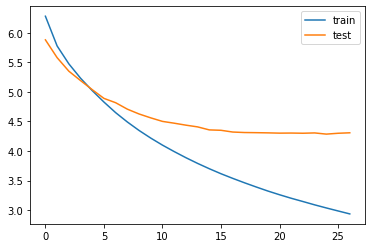

In [50]:
# train, test loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [51]:
# 정수 인덱스로 되어있던 텍스트 데이터를 실제 데이터로 복원하기

src_index_to_word = src_tokenizer.index_word    # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index    # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word    # 요약 던어 집합에서 정수 -> 단어를 얻음

In [52]:
# 인퍼런스 단계에서는 인코더 모델과 디코더 모델 분리해서 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해 초기 상태를 이전 시점 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련과정과 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h, state_c 를 버리지 않음
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [53]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# <span style="background-color:#E6E6FA"> 4-0. 요약문 출력하기 위한 함수 정리 (추상적 요약) </span>

In [72]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

def pred_headline(encoder_input_test, decoder_input_test, max_len = 38, strt_num = 50, end_num= 100):
    '''
    헤드라인을 요약해주는 함수
    '''
    
    start_time = check_time()
    
    for i in range(strt_num, end_num):
        
        real_summary = seq2summary(decoder_input_test[i])
        pred_summary = decode_sequence(encoder_input_test[i].reshape(1, max_len))
        
        print(">>> 원문 :", seq2text(encoder_input_test[i]))
        print(">>> 실제 요약 :", real_summary)
        print(">>> 예측 요약 :", pred_summary)
        print(">>> 실제와 예측에 포함되는 단어 :", find_same_word(real_summary, pred_summary))
        print("\n")
        
    end_time = check_time()
    print(f"{end_num-strt_num}개 추출에 걸리는 시간: {end_time - start_time:.5f} sec")
        
def find_same_word(real_sentence, pred_sentence):
    '''
    두개의 문장을 비교해서 같은 단어가 있는지 찾는 함수
    
    Args:
        real_sentence: 실제 요약
        pred_sentence: 예측 요약
    '''
    pred_word_list = pred_sentence.split() # 예측한 문장을 단어로 분리해서 찾음
    
    find_word_list = set()
    
    for pred_word in pred_word_list:
        if pred_word in real_sentence:
            find_word_list.add(pred_word)
            
    return find_word_list if len(find_word_list) != 0 else '없음'


def check_time():
    return time.time()

# <span style="background-color:#E6E6FA"> 4. 실제 결과와 요약문 비교하기 (추상적 요약) </span>

In [73]:
START_NUM = 10
END_NUM = 20

pred_headline(encoder_input_test, decoder_input_test, text_max_len, START_NUM, END_NUM)

>>> 원문 : mba student hanged hostel hyderabad video call boyfriend police said rushed hospital declared dead arrival police officials said recovered victim mobile phone investigating suicide 
>>> 실제 요약 : mba student hangs herself during video call with boyfriend 
>>> 예측 요약 :  girl jumps off self after she was hangs him
>>> 실제와 예측에 포함되는 단어 : {'self', 'hangs'}


>>> 원문 : rumour amazon start accepting bitcoin retail platform partially led value cryptocurrency bitcoin hit record high week according reports according analysts speculation china may reverse ban cryptocurrency exchanges also served reason friday bitcoin price reached time high 
>>> 실제 요약 : amazon rumour led to record high surge in bitcoin price 
>>> 예측 요약 :  amazon buys mn in billion startup
>>> 실제와 예측에 포함되는 단어 : {'in', 'amazon'}


>>> 원문 : year old woman killed allegedly husband laws mumbai body parts dumped different areas city victim priyanka went missing april husband registered missing person complaint police later recover

# <span style="background-color:#E6E6FA"> 5. Summa을 이용해서 추출적 요약해보기 </span>

### <span style="background-color:#fff5b1"> text 데이터 가져오기 </span> 

In [56]:
from summa.summarizer import summarize

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### <span style="background-color:#fff5b1"> summarize를 사용한 추출적 요약 함수 </span> 

In [74]:
def pred_summarize_ratio(data, strt_num = 10, end_num= 20, ratio = 0.2):
    '''
    Args:
        text (str) : 요약할 테스트.
        ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
        words (int or None, optional) – 출력에 포함할 단어 수.
        만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
        split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
    '''

    start_time = check_time()

    for i in range(strt_num, end_num):
        
        real_summary = data['headlines'][i]
        pred_summary = summarize(data['text'][i], ratio=ratio)
        
        print(">>> 원문 :", data['text'][i])
        print(">>> 실제 헤드라인 :", data['headlines'][i])
        print(">>> 예측 헤드라인 :", summarize(data['text'][i], ratio=ratio))
        print(">>> 실제와 예측에 포함되는 단어 :", find_same_word(real_summary, pred_summary))
        print("\n")
    end_time = check_time()
    print(f"{end_num-strt_num}개 추출에 걸리는 시간: {end_time - start_time:.5f} sec")
        
def pred_summarize_word(data, strt_num = 10, end_num= 20, words = 30):
    
    start_time = check_time()
    
    for i in range(strt_num, end_num):
        
        real_summary = data['headlines'][i]
        pred_summary = summarize(data['text'][i], words=words)
        
        print(">>> 원문 :", data['text'][i])
        print(">>> 실제 헤드라인 :", data['headlines'][i])
        print(">>> 예측 헤드라인 :", summarize(data['text'][i], words=words))
        print(">>> 실제와 예측에 포함되는 단어 :", find_same_word(real_summary, pred_summary))
        print("\n")
        
    end_time = check_time()
    print(f"{end_num-strt_num}개 추출에 걸리는 시간: {end_time - start_time:.5f} sec")

### <span style="background-color:#fff5b1"> 비율로 예측 헤드라인 출력 </span> 

In [75]:
RATIO = 0.45

pred_summarize_ratio(data, 10, 20, RATIO)

>>> 원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
>>> 실제 헤드라인 : UP cousins fed human excreta for friendship with boys
>>> 예측 헤드라인 : 
>>> 실제와 예측에 포함되는 단어 : 없음


>>> 원문 : Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily and spends eight hours conducting physical training, apart from climbing and yoga sessions. She says, "One should do something for society till one's last breath."
>>> 실제 헤드라인 : 81-yr-old woman conducts physical training in J'khand schools
>>> 예측 헤드라인 : Isha Ghosh, an 81-year-old 

### <span style="background-color:#fff5b1"> 단어 개수로 예측 헤드라인 출력 </span> 

In [76]:
WORDS = 15

pred_summarize_word(data, 10, 20, WORDS)

>>> 원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
>>> 실제 헤드라인 : UP cousins fed human excreta for friendship with boys
>>> 예측 헤드라인 : 
>>> 실제와 예측에 포함되는 단어 : 없음


>>> 원문 : Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily and spends eight hours conducting physical training, apart from climbing and yoga sessions. She says, "One should do something for society till one's last breath."
>>> 실제 헤드라인 : 81-yr-old woman conducts physical training in J'khand schools
>>> 예측 헤드라인 : Isha Ghosh, an 81-year-old 

# <span style="background-color:#C0FFFF"> Extractive, Abstractive 요약 결과 비교 </span>

두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

Abstractive  

   - 장점
      1. 원문의 표현을 재구성하기 때문에 더욱 폭넓은 요약이 가능해 보인다.
      
      2. 문장의 길이를 조절할 수 있다.
    
   - 단점
      1. 새로운 문장을 만들기 때문에 문법이 어색하다.
  
      2. summarize를 사용할 때보다 계산하는데 시간이 오래 걸리는 것을 볼 수 있다.

<br/>

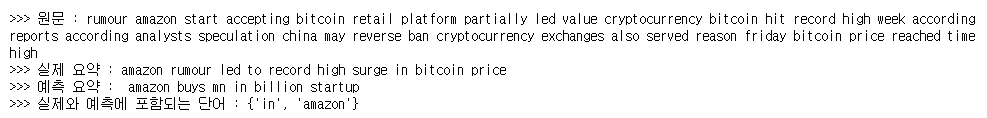 <br/> *[문장이 다르지만 특정 단어가 출력되는 것을 볼 수 있다.]*

---

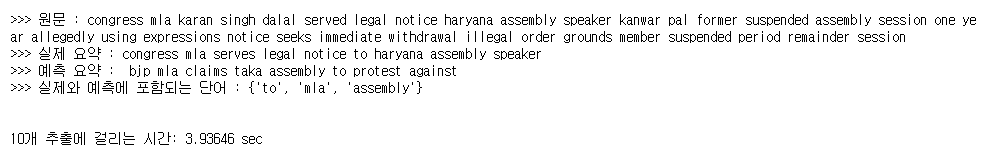 <br/> *[10개 추출에 걸리는 시간]*

<br/>

---

Extractive

   - 장점 
      1. 기사의 내용이 짧고 핵심적인 내용으로만 이루어져 있을 경우 요약 기능이 향상된다.

      2. 내용에서 추출하는 방식이기 때문에 문법적인 측면에서는 더 나은 결과를 보여준다.
    
   - 단점
      1.  같이 Ratio, Words의 비율이 너무 작을 경우 예상값이 출력이 안되는 경우가 많았는데 오늘 요약을 하려는 데이터에서는 Ratio는 0.45보다는 큰 값을 입력해야 예측 헤드라인이 잘 출력되는 것을 볼 수 있었다.
      
      2. 같은 단어가 연속으로 출력되는 문제가 있다.

<br/>

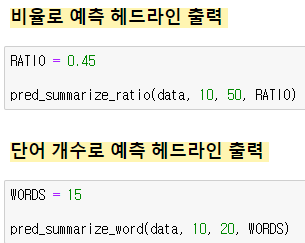 <br/> *[비율 설정]* |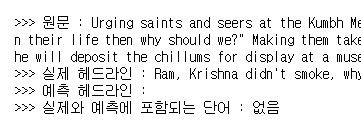 <br/> *[예상이 출력 안되는 문제]*
--- | --- | 

---

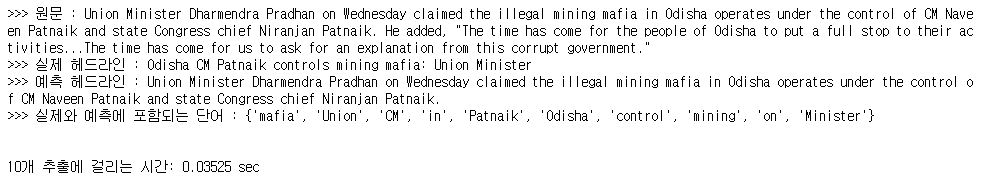 <br/> *[10개 추출에 걸리는 시간]*


# <span style="background-color:#C0FFFF"> 회고 </span>

이번 프로젝트에서는 뉴스를 추상적, 추출적 요약 내용을 만들어 보았는데 추상적 요약의 경우에 어텐션 메커니즘을 적용하여 가중치를 주는 부분에 대해서 신기하면서도 조금 더 이해가 필요하다고 생각했다.

그리고 오랜만에 코드를 정리하면서 작성했더니 할 때는 힘들었지만 만들고 보니 뿌듯하다.